In [1]:
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier



df_train = pd.read_csv(os.path.join('data','train.csv'))
df_test = pd.read_csv(os.path.join('data','test.csv'))

submission_df = pd.DataFrame(index=df_test['PassengerId'])

def get_title(name):
    title_list = ["Mr.", "Mrs.", "Miss.", "Master.", "Don.", "Rev.", "Dr.", "Mme.", "Ms.", 
        "Major.", "Lady.", "Sir.", "Mlle.", "Col.", "Capt.", "Countess.", "Jonkheer.", "Dona."]
    
    for title in title_list:
        if title in name:
            return title
    return None


def get_floor(cabin):
    """Returns a tuple of cabin floor and the number of the cabin"""
    if cabin == "null": return ["null",0]

    data = [re.findall("[a-zA-Z]+",cabin)[-1]]

    num = re.findall("\d+",cabin)
    if num:
        data.append(int(num[-1]))
    else:
        data.append(0)

    return data

def process(df):
    """This is going to do some feature engineering with the data to get better results"""
    ## Filling null values. Starting with Cabin feature, then age and embarked
    df["Cabin"].fillna("null", inplace=True)

    ## Filled age with 0 as the coefficient multiplying with 0 is going to have no effect, so as
    ## to make it so the age is not known, it won't impact the predictions (it might though)
    df["Age"].fillna(0,inplace=True)
    df["Embarked"].fillna("null",inplace=True)
    df["Fare"].fillna(0,inplace=True)

    ## Adding features to split up cabin into discrete and continuous features
    result_series = df["Cabin"].apply(lambda cabin: get_floor(cabin))
    df["Cabin Floor"] = result_series.str[0]
    df["Cabin Room"] = result_series.str[1]
    
    ## Going to add a new feature to represent the title of people, there might be an 
    ## important detail to predict survavibility
    df["Title"] = df["Name"].apply(lambda name: get_title(name))

    ## Dropping name afterwards as it is not going to help us
    df.drop("Cabin", axis=1, inplace=True)
    df.drop("Name", axis=1, inplace=True)
    df.drop(["PassengerId", "Ticket"], axis=1, inplace=True)

    
    return df


In [2]:
## Processing the features
df_train = process(df_train)
df_test = process(df_test)



In [3]:
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin Floor,Cabin Room,Title
0,0,3,male,22.0,1,0,7.2500,S,null,0,Mr.
1,1,1,female,38.0,1,0,71.2833,C,C,85,Mrs.
2,1,3,female,26.0,0,0,7.9250,S,null,0,Miss.
3,1,1,female,35.0,1,0,53.1000,S,C,123,Mrs.
4,0,3,male,35.0,0,0,8.0500,S,null,0,Mr.


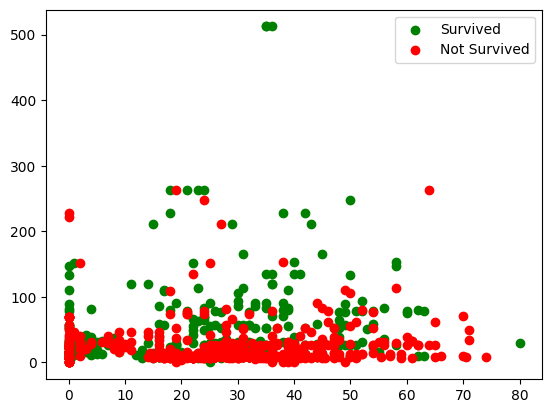

In [4]:
pos_df = df_train[df_train['Survived'] == 1]
neg_df = df_train[df_train['Survived'] == 0]
fig, ax = plt.subplots(1,1)
ax = plt.scatter(pos_df['Age'], pos_df['Fare'], c='g', label='Survived')
ax = plt.scatter(neg_df['Age'], neg_df['Fare'], c='r', label='Not Survived')
plt.legend()
plt.show()

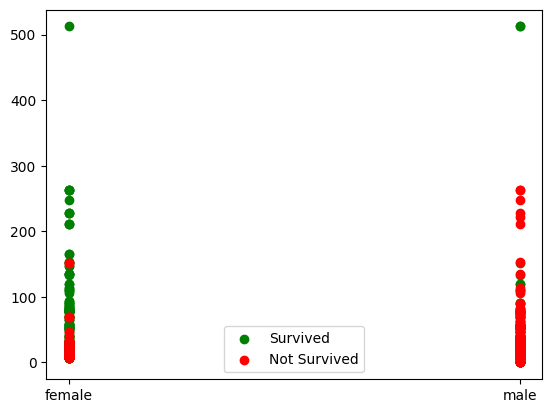

In [5]:
plt.close('all')
fig, ax = plt.subplots(1,1)
ax = plt.scatter(pos_df['Sex'], pos_df['Fare'], c='g', label='Survived')
ax = plt.scatter(neg_df['Sex'], neg_df['Fare'], c='r', label='Not Survived')
plt.legend()
plt.show()


In [6]:
y_train = df_train["Survived"]
x_train = df_train.drop("Survived",axis=1)

x_train = pd.get_dummies(x_train, dtype=int)
x_test = pd.get_dummies(df_test, dtype=int)

## Fitting the same columns to one another
train_col = x_train.columns
test_col = x_test.columns

remove_feat = [col_name for col_name in train_col if col_name not in test_col]
x_train_fit = x_train.drop(remove_feat, axis=1)

col_to_add = [col for col in test_col if col not in train_col]
index = test_col.get_indexer(col_to_add)[0]

x_train_fit.insert(int(index),col_to_add[0],0)

In [7]:
x_train_fit

,Pclass,Age,SibSp,Parch,Fare,Cabin Room,Sex_female,Sex_male,Embarked_C,Embarked_Q,...,Cabin Floor_null,Title_Col.,Title_Dona.,Title_Dr.,Title_Master.,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Ms.,Title_Rev.
0,3,22.0,1,0,7.2500,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0
1,1,38.0,1,0,71.2833,85,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,3,26.0,0,0,7.9250,0,1,0,0,0,...,1,0,0,0,0,1,0,0,0,0
3,1,35.0,1,0,53.1000,123,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,3,35.0,0,0,8.0500,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,27.0,0,0,13.0000,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
887,1,19.0,0,0,30.0000,42,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
888,3,0.0,1,2,23.4500,0,1,0,0,0,...,1,0,0,0,0,1,0,0,0,0
889,1,26.0,0,0,30.0000,148,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0


In [8]:
x_train_fit['Age * Fare'] = x_train_fit.Age * x_train_fit.Fare
x_test['Age * Fare'] = x_test.Age * x_test.Fare
x_train_fit

,Pclass,Age,SibSp,Parch,Fare,Cabin Room,Sex_female,Sex_male,Embarked_C,Embarked_Q,...,Title_Col.,Title_Dona.,Title_Dr.,Title_Master.,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Ms.,Title_Rev.,Age * Fare
0,3,22.0,1,0,7.2500,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,159.5000
1,1,38.0,1,0,71.2833,85,1,0,1,0,...,0,0,0,0,0,0,1,0,0,2708.7654
2,3,26.0,0,0,7.9250,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,206.0500
3,1,35.0,1,0,53.1000,123,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1858.5000
4,3,35.0,0,0,8.0500,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,281.7500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,27.0,0,0,13.0000,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,351.0000
887,1,19.0,0,0,30.0000,42,1,0,0,0,...,0,0,0,0,1,0,0,0,0,570.0000
888,3,0.0,1,2,23.4500,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0.0000
889,1,26.0,0,0,30.0000,148,0,1,1,0,...,0,0,0,0,0,1,0,0,0,780.0000


In [9]:
scaler = StandardScaler()
col_to_scale = ['Age','Fare','Cabin Room', 'Age * Fare']

scaled_train = x_train_fit
scaled_train[col_to_scale] = scaler.fit_transform(x_train_fit[col_to_scale])

scaled_test = x_test
scaled_test[col_to_scale] = scaler.fit_transform(x_test[col_to_scale])

In [10]:
## Getting result
    ## Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(scaled_train,y_train)
result = model.predict(scaled_test)

In [13]:
coeff = model.coef_
np.savetxt('trained_coeff.csv',coeff)
coeff

array([[-7.21873072e-01, -3.15590213e-01, -4.58177766e-01,
        -3.02497168e-01, -1.04131495e-02,  1.44264494e-03,
         1.02491862e+00, -1.02754316e+00,  2.05272016e-01,
        -1.36115998e-01, -1.63650188e-01, -1.03459216e-01,
        -1.32425252e-02, -3.37902231e-01,  5.67644066e-01,
         8.49836058e-01,  4.18234941e-01, -5.59194325e-01,
        -4.83694406e-01, -1.26134133e-02,  0.00000000e+00,
        -2.97779771e-01,  2.19905314e+00, -5.82573802e-02,
        -1.01611822e+00,  5.27239828e-01,  1.82661684e-01,
        -8.07722999e-01,  2.83247748e-01]])

In [12]:
submission_df["Survived"] = result
submission_df.to_csv(os.path.join('results','result_engg.csv'))